![alt text](https://www.arkavidia.id/_nuxt/img/a10a78c.svg)

This notebook belongs to **Sour Soup Team**

---

# Cross Sell Transactions

Pada *notebook* ini, kami akan memprediksi apakah akan terjadi *cross sell* pada transaksi penerbangan pelanggan [tiket.com](https://www.tiket.com), proses ini dikategorikan sebagai klasifikasi. *Cross sell* adalah ketika pelanggan membuat booking hotel bersamaan dengan membeli tiket pesawat.

> [Tiket.com](https://www.tiket.com) adalah situs web yang menyediakan layanan pemesanan hotel, tiket pesawat, tiket kereta api, penyewaan mobil, tiket konser, tiket atraksi, tiket hiburan, dan tiket event yang berbasis di Jakarta, Indonesia.

Untuk melakukan proses klasifikasi, kami menggunakan alur *data science* yang umum digunakan pada gambar dibawah ini:

![](https://d3ansictanv2wj.cloudfront.net/Figure3-85d4b2a80132afe42305cb3b4b6c3aa8.png)


## Import Library

Tools yang akan digunakan pada seluruh proses.

In [1]:
# helper libraries
from __future__ import print_function

import os
import gc
import ast
import csv
import datetime
import random
import numpy as np
import pandas as pd
import pandas_profiling as pp
from scipy.special import expit

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [8,8]

# Model libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier

# Helper
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import SCORERS, f1_score, make_scorer, classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

# Imblearn libraries
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# add path to directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


/kaggle/input/datavidia2019/flight.csv
/kaggle/input/datavidia2019/sample_submission.csv
/kaggle/input/datavidia2019/Data Dictionary.pdf
/kaggle/input/datavidia2019/hotel.csv
/kaggle/input/datavidia2019/test.csv


## Dataset

Berikut ini data yang tersedia dan akan digunakan untuk proses klasifikasi:

- `flight.csv` - Data *training* yang berisi berbagai *flight 
transactions* beserta atribut-atributnya
- `hotel.csv` - Berisi data hotel dan atribut-atributnya
- `test.csv` - Data *test* yang berisi *flight transactions* yang harus diprediksi apakah terjadi *cross selling* atau tidak
- `sample_submission.csv` - Berisi format submisi ke Kaggle

In [2]:
# directory kernel
dirname = '/kaggle/input/datavidia2019/'

# dataframes for each files
df_hotel = pd.read_csv(dirname+'hotel.csv')
df_flight = pd.read_csv(dirname+'flight.csv')
df_test = pd.read_csv(dirname+'test.csv')
sample = pd.read_csv(dirname+'sample_submission.csv')

### Data Penerbangan

Data yang terdapat pada file `flight.csv` memiliki fitur sebagai berikut:

- `account_id` : *unique key* dari pelanggan [tiket.com](https://www.tiket.com)
- `order_id` : *unique key* dari pesanan pelanggan
- `member_duration_days` : durasi member pelanggan sejak awal mendaftar
- `gender` : jenis kelamin
- `trip` : tipe perjalanan
- `service_class` : tipe layanan maskapai
- `price` : harga penerbangan
- `is_tx_promo` : penggunaan promosi saat transaksi penerbangan
- `no_of_seats` : jumlah kursi yang dipesan pelanggan
- `airlines_name` : nama maskapai
- `route` : rute penerbangan
- `hotel_id` : *unique key* dari hotel yang dipesan
- `visited_city` : daftar kota yang telah dikunjungi pelanggan
- `log_transaction` : daftar pengeluaran yang telah dihabiskan pelanggan

adapun tampilan 5 data teratas pada file `flight.csv` sebagai berikut:

In [3]:
df_flight.head()

account_id                          order_id  \
0  912aa410a02cd7e1bab414214a7005c0  5c6f39c690f23650d3cde28e5b51c908   
1  d64a90a618202a5e8b25d8539377f3ca  5cbef2b87f51c18bf399d11bfe495a46   
2  1a42ac02bcb4a902973123323f84da55  38fc35a1e62384012a358ab1fbd5ad03   
3  92cddd64d4be4dec6dfbcc0c50e902f4  c7f54cb748828b4413e02dea2758faf6   
4  bf637abc47ea93bad22264f4956d67f6  dec228e4d2b6023c9f1fe9cfe9c451bf   

   member_duration_days gender  trip service_class       price is_tx_promo  \
0                 566.0      M  trip       ECONOMY   885898.00          NO   
1                 607.0      M  trip       ECONOMY  2139751.25          NO   
2                 648.0      F  trip       ECONOMY  2695550.00          NO   
3                 418.0      F  trip       ECONOMY  1146665.00          NO   
4                 537.0      F  trip       ECONOMY  1131032.50          NO   

   no_of_seats                     airlines_name      route hotel_id  \
0          1.0  33199710eb822fbcfd0dc793f4788d30  CGK - DPS     None   
1          2.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
2          1.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
3          1.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
4          1.0  6c483c0812c96f8ec43bb0ff76eaf716  CGK - DPS     None   

                                        visited_city  \
0         '['Semarang', 'Jakarta', 'Medan', 'Bali']'   
1                     '['Jakarta', 'Medan', 'Bali']'   
2         '['Semarang', 'Jakarta', 'Medan', 'Bali']'   
3       '['Jogjakarta', 'Bali', 'Jakarta', 'Medan']'   
4  '['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'S...   

                                     log_transaction  
0      '[545203.03, 918492.11, 1774241.4, 885898.0]'  
1  '[555476.36, 2422826.84, 7398697.64, 7930866.8...  
2  '[7328957.45, 7027662.34, 1933360.88, 3461836....  
3              '[5243631.69, 2474344.48, 1146665.0]'  
4  '[9808972.98, 9628619.79, 6712680.0, 5034510.0...

### Data Hotel

Data yang terdapat pada file `hotel.csv` memiliki fitur sebagai berikut:

- `hotel_id` : *unique key* dari hotel yang dipesan
- `starRating` : rating hotel
- `city` : kota hotel berada
- `free_wifi` : fasilitas wifi gratis
- `pool_access` : fasilitas kolam renang
- `free_breakfast` : fasilitas sarapan gratis

adapun tampilan 5 data teratas pada file `hotel.csv` sebagai berikut:

In [4]:
df_hotel.head()

hotel_id  starRating  city free_wifi pool_access  \
0  e2733e84102226acf6b53bffd2e60cf8         0.0  bali       YES          NO   
1  9f9de5df06d64ada1026e930687a87e4         0.0  bali       YES          NO   
2  3cf6774fb4dc331bb49e7a959b74a67e         0.0  bali       YES          NO   
3  eca261898220478834072b0c753a5229         0.0  bali       YES          NO   
4  c21f400013fa4f244a7168a3c155b8b5         0.0  bali       YES          NO   

  free_breakfast  
0             NO  
1             NO  
2             NO  
3             NO  
4             NO

## Data Preprocessing

Pada bagian data *preprocessing*, kami melakukan dua proses. Pertama, kami membuat dataframe baru yaitu `df_train` dan fitur baru pada dataframe tersebut sebagai variabel target yaitu `is_cross_sell`. Fitur `is_cross_sell` berdasarkan pada fitur `hotel_id` pada `df_train`. Jika `hotel_id` bernilai `None` maka tidak terjadi cross selling pada transaksi tersebut (`yes`) dan sebaliknya (`no`).

Kedua, kami mengubah tipe data fitur `log_transaction` dan `visited_city` masing-masing diubah dari string menjadi **list** dan **tuple**.

In [5]:
df_train = df_flight.copy()
df_train['is_cross_sell'] = ~(df_flight['hotel_id']=='None')

*Helper functions* dibawah ini adalah untuk membantu mengubah data object **string** menjadi **list**, sehingga fitur dapat diolah dengan baik.

In [6]:
def string_to_list(x):
    x = ast.literal_eval(x)
    x =  ast.literal_eval(x)
    return x
    
def string_to_list2(x):
    x = x.strip()
    x = ast.literal_eval(x)
    return x

*Helper function* dibawah ini berfungsi untuk mengekstrak nilai yang terdapat pada fitur `log_transaction`. Pada fitur tersebut akan kami ubah tipe datanya menjadi list sehingga kami dapat diambil nilai **max**, **min**, **mean**, **sum**, **std**, dan **panjang dari list** masing-masing baris.

In [7]:
def log_tx(df):
    df['log_transaction'] = df['log_transaction'].apply(string_to_list)    
    df['max_log_transaction'] = df['log_transaction'].apply(max)
    df['min_log_transaction'] = df['log_transaction'].apply(min)
    df['mean_log_transaction'] = df['log_transaction'].apply(np.mean)
    df['len_log_transaction'] = df['log_transaction'].apply(len)
    df['sum_log_transaction'] = df['log_transaction'].apply(np.sum)
    df['sum_log_transaction'] = df['log_transaction'].apply(np.std)

    df.drop(['log_transaction'],inplace=True,axis=1)

log_tx(df_train)
log_tx(df_test)

In [8]:
gc.collect()

648

data *train* yang telah melalui *preprocessing* menggunakan *helper functions* diatas adalah sebagai berikut:

In [9]:
df_train.head()

account_id                          order_id  \
0  912aa410a02cd7e1bab414214a7005c0  5c6f39c690f23650d3cde28e5b51c908   
1  d64a90a618202a5e8b25d8539377f3ca  5cbef2b87f51c18bf399d11bfe495a46   
2  1a42ac02bcb4a902973123323f84da55  38fc35a1e62384012a358ab1fbd5ad03   
3  92cddd64d4be4dec6dfbcc0c50e902f4  c7f54cb748828b4413e02dea2758faf6   
4  bf637abc47ea93bad22264f4956d67f6  dec228e4d2b6023c9f1fe9cfe9c451bf   

   member_duration_days gender  trip service_class       price is_tx_promo  \
0                 566.0      M  trip       ECONOMY   885898.00          NO   
1                 607.0      M  trip       ECONOMY  2139751.25          NO   
2                 648.0      F  trip       ECONOMY  2695550.00          NO   
3                 418.0      F  trip       ECONOMY  1146665.00          NO   
4                 537.0      F  trip       ECONOMY  1131032.50          NO   

   no_of_seats                     airlines_name      route hotel_id  \
0          1.0  33199710eb822fbcfd0dc793f4788d30  CGK - DPS     None   
1          2.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
2          1.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
3          1.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
4          1.0  6c483c0812c96f8ec43bb0ff76eaf716  CGK - DPS     None   

                                        visited_city  is_cross_sell  \
0         '['Semarang', 'Jakarta', 'Medan', 'Bali']'          False   
1                     '['Jakarta', 'Medan', 'Bali']'          False   
2         '['Semarang', 'Jakarta', 'Medan', 'Bali']'          False   
3       '['Jogjakarta', 'Bali', 'Jakarta', 'Medan']'          False   
4  '['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'S...          False   

   max_log_transaction  min_log_transaction  mean_log_transaction  \
0           1774241.40            545203.03          1.030959e+06   
1          18685958.20            555476.36          2.646397e+06   
2           7328957.45           1933360.88          4.489474e+06   
3           5243631.69           1146665.00          2.954880e+06   
4          13563940.00            951639.00          4.362199e+06   

   len_log_transaction  sum_log_transaction  
0                    4         4.533539e+05  
1                 1086         2.624008e+06  
2                    5         2.250021e+06  
3                    3         1.706745e+06  
4                  157         3.006539e+06

*Helper function* dibawah ini berfungsi untuk mengubah tipe data fitur `visited_city`. Pada fitur tersebut akan kami ubah tipe datanya menjadi dari **string** menjadi **list** tapi karena list ada tipe data yang ``unhashable`` maka kami mengubah lagi menjadi **tuple** agar dapat di modifikasi.

In [10]:
def visited_pre(df):
    df['visited_city'] = df['visited_city'].apply(lambda x: x[1:-1])
    df['visited_city'] = df['visited_city'].apply(string_to_list2)
    df['visited_city'] = df['visited_city'].apply(tuple)

visited_pre(df_train)
visited_pre(df_test)

data *train* yang telah melalui *preprocessing* menggunakan *helper function* diatas adalah sebagai berikut:

In [11]:
df_train.head()

account_id                          order_id  \
0  912aa410a02cd7e1bab414214a7005c0  5c6f39c690f23650d3cde28e5b51c908   
1  d64a90a618202a5e8b25d8539377f3ca  5cbef2b87f51c18bf399d11bfe495a46   
2  1a42ac02bcb4a902973123323f84da55  38fc35a1e62384012a358ab1fbd5ad03   
3  92cddd64d4be4dec6dfbcc0c50e902f4  c7f54cb748828b4413e02dea2758faf6   
4  bf637abc47ea93bad22264f4956d67f6  dec228e4d2b6023c9f1fe9cfe9c451bf   

   member_duration_days gender  trip service_class       price is_tx_promo  \
0                 566.0      M  trip       ECONOMY   885898.00          NO   
1                 607.0      M  trip       ECONOMY  2139751.25          NO   
2                 648.0      F  trip       ECONOMY  2695550.00          NO   
3                 418.0      F  trip       ECONOMY  1146665.00          NO   
4                 537.0      F  trip       ECONOMY  1131032.50          NO   

   no_of_seats                     airlines_name      route hotel_id  \
0          1.0  33199710eb822fbcfd0dc793f4788d30  CGK - DPS     None   
1          2.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
2          1.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
3          1.0  0a102015e48c1f68e121acc99fca9a05  CGK - DPS     None   
4          1.0  6c483c0812c96f8ec43bb0ff76eaf716  CGK - DPS     None   

                                   visited_city  is_cross_sell  \
0              (Semarang, Jakarta, Medan, Bali)          False   
1                        (Jakarta, Medan, Bali)          False   
2              (Semarang, Jakarta, Medan, Bali)          False   
3            (Jogjakarta, Bali, Jakarta, Medan)          False   
4  (Jakarta, Bali, Medan, Jogjakarta, Semarang)          False   

   max_log_transaction  min_log_transaction  mean_log_transaction  \
0           1774241.40            545203.03          1.030959e+06   
1          18685958.20            555476.36          2.646397e+06   
2           7328957.45           1933360.88          4.489474e+06   
3           5243631.69           1146665.00          2.954880e+06   
4          13563940.00            951639.00          4.362199e+06   

   len_log_transaction  sum_log_transaction  
0                    4         4.533539e+05  
1                 1086         2.624008e+06  
2                    5         2.250021e+06  
3                    3         1.706745e+06  
4                  157         3.006539e+06

## Exploratory Data Analysis (EDA)

### Profiling
Pada bagian ini, kami menggunakan pandas profiling sebagai tools dasar EDA pada `df_train` dan `df_test`. *Tools* tersebut memberikan *insights* mulai dari **jumlah fitur; nilai mean, min, max; *distinct values*; dan visualisasi masing-masing fitur** dari data `df_train` dan `df_test`.  Berikut ini hasil EDA untuk `df_train`:

In [12]:
df_train.profile_report()

Berikut ini hasil EDA untuk `df_test`:

In [13]:
df_test.profile_report()

### Visualisasi

Agar data dapat dipahami dengan baik, visualisasi keterkaitan antara fitur-fitur yang ada dengan `is_cross_sell` perlu dilakukan. Selain untuk lebih memahami karakter data, kami dapat menganalisis lebih jauh hubungan `is_cross_sell` dengan fitur lainnya. Visualisasi menggunakan **scatter plot** dan **bar plot**

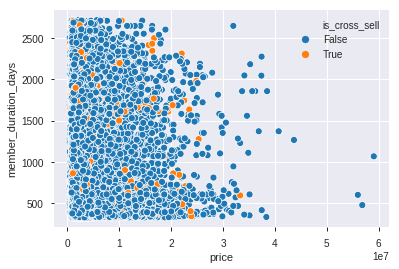

In [14]:
sns.scatterplot(data=df_train,x='price',y='member_duration_days',hue='is_cross_sell')

Dapat dilihat dari *scatter plot* diatas, persebaran dari harga dan durasi member terhadap *cross sell* menyebar sehingga harga dan durasi member tidak cukup untuk menentukan apakah suatu transaksi terjadi *cross sell* atau tidak. 

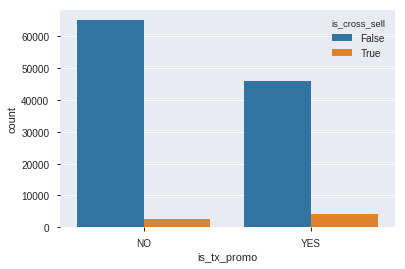

In [15]:
sns.countplot(data=df_train,x='is_tx_promo',hue='is_cross_sell')

Dari *bar plot* diatas dapat disimpulkan bahwa baik ada promo maupun tidak, transaksi tanpa *cross sell* banyak terjadi dengan lebih dari 45000 transaksi.  

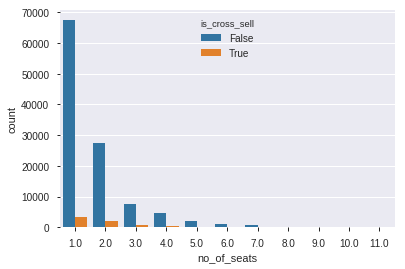

In [16]:
sns.countplot(data=df_train,x='no_of_seats',hue='is_cross_sell')

Dapat dilihat bahwa pelanggan yang membeli lebih dari 5 tiket dalam sekali order hampir tidak pernah memesan hotel, asumsi kami bahwa pelanggan yang memesan lebih dari 5 tiket adalah keluarga yang mudik atau berkunjung ke rumah sanak saudara.

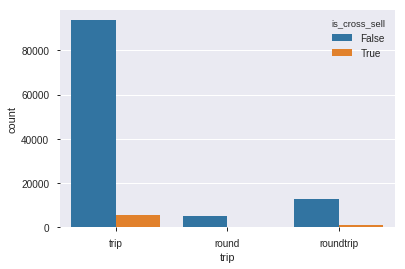

In [17]:
sns.countplot(data=df_train,x='trip',hue='is_cross_sell')

Pada fitur `trip`, lebih banyak bernilai `trip` yang melakukan transaksi *cross sell*. kami menganggap nilai `roundtrip` dan `round` merupakan nilai yang sama, karena memiliki definisi yang cukup mirip dan banyak nilai `round` yang terlalu sedikit.

[('Semarang', 'Jakarta', 'Medan', 'Bali') ('Jakarta', 'Medan', 'Bali')
 ('Jogjakarta', 'Bali', 'Jakarta', 'Medan')
 ('Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'Semarang')
 ('Bali', 'Jakarta', 'Medan') ('Medan', 'Bali', 'Jakarta')
 ('Manado', 'Medan', 'Bali', 'Jakarta')
 ('Surabaya', 'Medan', 'Bali', 'Jakarta', 'Aceh')]


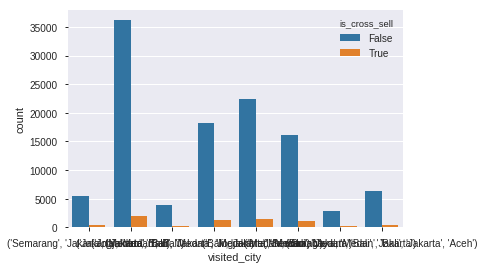

In [18]:
# nilai unik dari visited_city`
print(df_train['visited_city'].unique())

sns.countplot(data=df_train,x='visited_city',hue='is_cross_sell',orient='v')

Pelanggan yang pernah mengunjungi `('Jakarta', 'Medan', 'Bali')` paling banyak melakukan transaksi *cross sell* maupun tidak.

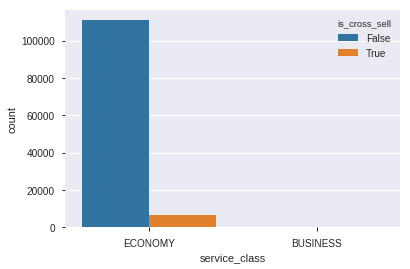

In [19]:
sns.countplot(data=df_train,x='service_class',hue='is_cross_sell',orient='v')

Pada fitur `service_class` jauh lebih banyak row yang bernilai `economy` daripada `businesss` sehingga kami rasa fitur ini tidak layak untuk dianalisa lebih lanjut.

### Processing EDA
Dari EDA diatas kami memutuskan untuk melakukan proses berikut:

1. Menghapus fitur:
  - `service_class` : lebih banyak bernilai **economy**.
  - `route` : hanya memiliki **satu** nilai,
  - `log_transaction` : sudah mengambil **nilai min, max, mean, median, std, sum dan count** (Proses ini telah dilakukan bersamaan dengan pengambilan nilai-nilai tersebut).

In [20]:
df_train.drop(['service_class','route'],axis=1,inplace=True)
df_test.drop(['service_class','route'],axis=1,inplace=True)

2. Mengkombinasikan nilai menjadi satu pada suatu fitur :
  - `trip` : **roundtrip** dan **round** menjadi **round** saja.

In [21]:
df_train['trip'] = np.where(df_train['trip']=='roundtrip', 'round', df_train['trip'])
df_test['trip'] = np.where(df_test['trip']=='roundtrip', 'round', df_test['trip'])

3. Mentransformasi nilai pada fitur `member_duration_days`, `price`, `max_log_transaction`, `min_log_transaction`, `mean_log_transaction`, `len_log_transaction`, dan `sum_log_transaction` yang bertipe numerik menggunakan logaritma natural.

Sebelum melakukan *normalisasi*, kami terlebih dahulu mengubah nilai negatif pada fitur `min_log_transaction` menjadi nilai **mean** fitur tersebut.

In [22]:
df_train['min_log_transaction'] = np.where(df_train['min_log_transaction'] < 0 ,  df_train['min_log_transaction'].mean(), df_train['min_log_transaction'])
df_test['min_log_transaction'] = np.where(df_test['min_log_transaction'] < 0, df_test['min_log_transaction'].mean(), df_test['min_log_transaction'])

In [23]:
cols = df_train.drop('no_of_seats',axis=1).select_dtypes([np.number]).columns
for col in cols:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])    

## Feature Engineering

### New Features
Proses ini merupakan pembuatan fitur baru menggunakan fitur yang sudah ada dan *insights* yang telah dianalisis pada proses EDA sebelumnya. Pada proses *feature engineering* ini, kami membuat beberapa fitur baru, yaitu:

- `count_use_hotel` : berapa kali pelanggan bersangkutan memesan hotel?
- `mode_facility_hotel` : *mode* dari fasilitas suatu hotel.
- `mode_rate_hotel` : *mode* rating yang diberikan oleh pelanggan.
- `count_user_id` : berapa kali customer melakukan transaksi.
- `count_user_id_with_air` : Berapa kali customer memesan dengan maskapai yang sama.
- `how_many_city` : berapa kota yang telah pelanggan kunjungi.
- `mean_price_air` : rata-rata harga setiap maskapai.
- `price_per_seat` : harga untuk tiap kursi yang dipesan.
- `order_rate` : jumlah berapa kali customer melakukan transaksi.

Untuk membuat fitur `count_use_hotel`, kami menggunakan aggregasi `account_id` dan `hotel_id` dan menggunakan *helper function* `count_hotel(x)` untuk menentukan berapa kali pelanggan [tiket.com](https://www.tiket.com) memesan tiket bersamaan dengan hotel.

Dan untuk fitur yang membutuhkan hotel id terdapat 2 kemungkinan nilai NaN dimana sebuah order memesan hotel yang tidak terdapat pada dataframe hotel atau tidak memesan hotel sama sekali, untuk kasus pertama kami menggunakan -999 untuk mengganti nilai NaN nya dan -1 untuk kasus kedua agar model dapat membedakan kedua kasus tersebut.

In [24]:
# list of account that ever use hotel
account_with_hotel = df_train[df_train['hotel_id']!='None'].groupby('account_id').agg('count')['order_id']

def count_hotel(x):
    if x in account_with_hotel:
        return account_with_hotel[x]
    return 0

# add ever_use_hotel into dataframe
df_train['count_use_hotel'] = df_train['account_id'].apply(count_hotel)
df_test['count_use_hotel'] = df_test['account_id'].apply(count_hotel)

Sebelum membuat fitur `mode_facility_hotel`, kami tambahkan fitur `fasilitas` di `df_hotel` yang berisikan *banyak* fasilitas yang tersedia pada suatu hotel.

In [25]:
df_hotel["free_wifi_bool"] = np.where(df_hotel["free_wifi"] == 'YES', 1, 0)
df_hotel["pool_access_bool"] = np.where(df_hotel['pool_access'] == 'YES', 1, 0)
df_hotel["free_breakfast_bool"] = np.where(df_hotel['free_breakfast'] == 'YES', 1, 0)
df_hotel['fasilitas'] = df_hotel['free_wifi_bool'] + df_hotel['pool_access_bool'] + df_hotel['free_breakfast_bool']

Untuk membuat fitur `mode_facility_hotel`, kami menggunakan aggregasi `account_id` dan `fasilitas` dan menggunakan *helper function* `mode_facility_hotel(x)` untuk menentukan ***mode*** fasilitas dari suatu hotel.

In [26]:
# list of mode of facility in a hotel
mode_fasilitas = pd.merge(df_train[df_train['hotel_id']!='None'],df_hotel,on='hotel_id',how='left').fillna(-999).groupby('account_id')['fasilitas'].agg(lambda x:x.value_counts().index[0])

def mode_facilty_hotel(x):
    if x in mode_fasilitas:
        return mode_fasilitas[x]
    return -1

# add mode_facility_hotel into dataframe
df_train['mode_facilty_hotel'] = df_train['account_id'].apply(mode_facilty_hotel)
df_test['mode_facilty_hotel'] = df_test['account_id'].apply(mode_facilty_hotel)

![](http://)Untuk membuat fitur `mode_star_rating`, kami menggunakan mengkombinasikan `account_id` dan `hotel_id` sehingga  menggunakan *helper function* `mode_rate_hotel(x)` untuk menentukan **modus dari rating** hotel yang digunakan oleh pelanggan.

In [27]:
# list of mode star rating in a hotel
mode_star_rating = pd.merge(df_train[df_train['hotel_id']!='None'],df_hotel,on='hotel_id',how='left').fillna(-999).groupby('account_id')['starRating'].agg(lambda x:x.value_counts().index[0])

def mode_rate_hotel(x):
    if x in mode_star_rating:
        return mode_star_rating[x]
    return -1

# add avg_rate_hotel into dataframe
df_train['mode_rate_hotel'] = df_train['account_id'].apply(mode_rate_hotel)
df_test['mode_rate_hotel'] = df_test['account_id'].apply(mode_rate_hotel)

Untuk membuat fitur `count_user_id`, kami aggregasi fitur `account_id` dan `order_id` untuk melihat jumlah transaksi pada seorang pelanggan.

In [28]:
# Count how many he/she already done an order
df_train['count_user_id'] = df_train.groupby(['account_id'])['order_id'].transform('count')
df_test['count_user_id'] = df_test.groupby(['account_id'])['order_id'].transform('count')

Untuk membuat fitur `count_user_id_with_air`, kami aggregasi fitur `account_id`, `airlines_name` dan `order_id` untuk melihat jumlah transaksi pada suatu maskapai.

In [29]:
# Count how many he/she already done an order within specified airlines
df_train['count_user_id_with_air'] = df_train.groupby(['account_id','airlines_name'])['order_id'].transform('count')
df_test['count_user_id_with_air'] = df_test.groupby(['account_id','airlines_name'])['order_id'].transform('count')

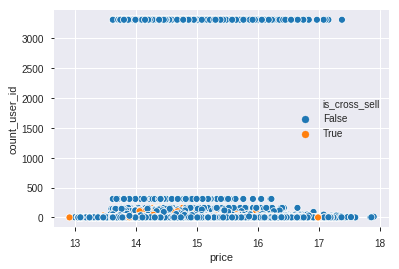

In [30]:
sns.scatterplot(data=df_train,x='price',y='count_user_id',hue='is_cross_sell')

*Scatter plot* diatas memperlihatkan banyaknya transaksi dan harga penerbangan serta apakah terjadi *cross sell* atau tidak.

Untuk membuat fitur `how_many_city`, kami menggunakan fitur `visited_city` dengn kode dibawah ini sehingga didapatkan jumlah kota yang dikunjungi oleh pelanggan sebelum melakukan transaksi.

In [31]:
# count how many cities was visited
df_train['how_many_city'] = df_train['visited_city'].apply(lambda x: len(x))
df_test['how_many_city'] = df_test['visited_city'].apply(lambda x: len(x))

Kemudian untuk membuat `mean_price_air`, kami menggunakan aggregasi fitur `airlines_name` dan `price` untuk menghitung **mean** sehingga didapatkan rata-rata harga pada setiap maskapai yang ada.

In [32]:
df_prices = df_train.groupby(['airlines_name'])['price'].mean().reset_index()
df_train = pd.merge(df_train,df_prices,on='airlines_name',how='left')
df_train = df_train.rename(columns={'price_y':'mean_price_air'})

df_prices = df_test.groupby(['airlines_name'])['price'].mean().reset_index()
df_test = pd.merge(df_test,df_prices,on='airlines_name',how='left')
df_test = df_test.rename(columns={'price_y':'mean_price_air'})

Fitur `price_per_seat` didapatkan dari fitur `price_x` / `no_of_seats`, yakni harga pada order dibagi dengan jumlah kursi yang dipesan. Proses tersebut menghasilkan rata-rata **harga kursi** untuk maskapai terkait.

In [33]:
# Price for each seat
df_train['price_per_seat'] = df_train['price_x']/df_train['no_of_seats']
df_test['price_per_seat'] = df_test['price_x']/df_test['no_of_seats']

Fitur `order_rate` didapatkan dari fitur `len_log_transaction` / `member_duration_days`, yakni banyaknya transaksi yang dilakukan oleh pelanggan dibagi dengan lamanya pelanggan menjadi member [tiket.com](https://www.tiket.com). Fitur ini mengindikasikan **seberapa sering** pelanggan melakukan transaksi sejak pelanggan terdaftar menjadi member [tiket.com](https://www.tiket.com).

In [34]:
# Order Rate of Customer
df_train['order_rate'] = df_train['len_log_transaction']/df_train['member_duration_days']
df_test['order_rate'] = df_test['len_log_transaction']/df_test['member_duration_days']

Berikut ini hasil *feature engineering* yang telah kami lakukan pada `df_train` dan `df_test`:

In [35]:
display(df_train.head())
display(df_test.head())

account_id                          order_id  \
0  912aa410a02cd7e1bab414214a7005c0  5c6f39c690f23650d3cde28e5b51c908   
1  d64a90a618202a5e8b25d8539377f3ca  5cbef2b87f51c18bf399d11bfe495a46   
2  1a42ac02bcb4a902973123323f84da55  38fc35a1e62384012a358ab1fbd5ad03   
3  92cddd64d4be4dec6dfbcc0c50e902f4  c7f54cb748828b4413e02dea2758faf6   
4  bf637abc47ea93bad22264f4956d67f6  dec228e4d2b6023c9f1fe9cfe9c451bf   

   member_duration_days gender  trip    price_x is_tx_promo  no_of_seats  \
0              6.340359      M  trip  13.694358          NO          1.0   
1              6.410175      M  trip  14.576201          NO          2.0   
2              6.475433      F  trip  14.807113          NO          1.0   
3              6.037871      F  trip  13.952369          NO          1.0   
4              6.287859      F  trip  13.938642          NO          1.0   

                      airlines_name hotel_id  ... sum_log_transaction  \
0  33199710eb822fbcfd0dc793f4788d30     None  ...           13.024431   
1  0a102015e48c1f68e121acc99fca9a05     None  ...           14.780214   
2  0a102015e48c1f68e121acc99fca9a05     None  ...           14.626451   
3  0a102015e48c1f68e121acc99fca9a05     None  ...           14.350099   
4  6c483c0812c96f8ec43bb0ff76eaf716     None  ...           14.916300   

   count_use_hotel  mode_facilty_hotel  mode_rate_hotel  count_user_id  \
0                0                -1.0             -1.0              2   
1                0                -1.0             -1.0           3311   
2                0                -1.0             -1.0              3   
3                0                -1.0             -1.0              1   
4               10                 1.0              4.0            161   

   count_user_id_with_air  how_many_city  mean_price_air  price_per_seat  \
0                       1              4       14.435097       13.694358   
1                     575              3       14.640493        7.288100   
2                       1              4       14.640493       14.807113   
3                       1              4       14.640493       13.952369   
4                     103              5       14.531102       13.938642   

   order_rate  
0    0.253840  
1    1.090637  
2    0.276701  
3    0.229600  
4    0.805138  

[5 rows x 26 columns]

account_id                          order_id  \
0  89a5fadd4d596610ff56044b9a0b1f4f  5ca64fd80a069208e3c0aa05dd580fb8   
1  86b28323bec6d938d47cee887e509b28  aca60904549a8a5958fe7a642efcb534   
2  36ef956ac3ef963c48e67327a4b6cc78  1771011e3adec5db9f30d15b3d439711   
3  f7821289404d44db50eb2edd4f82ea5b  6fc1b7d590c2a8c539ce56397403194d   
4  f62f33d1de5aabc919b69b1b5697f27a  c1f4712f60cd758e773555690d148764   

   member_duration_days gender   trip    price_x is_tx_promo  no_of_seats  \
0              7.470224      M   trip  14.960816         YES            3   
1              6.989335      F   trip  14.588673          NO            2   
2              7.774436      M  round  14.030312          NO            1   
3              6.357842      F   trip  14.500656         YES            2   
4              6.760415      F   trip  14.910993         YES            1   

                      airlines_name  \
0  e35de6a36d385711a660c72c0286154a   
1  e35de6a36d385711a660c72c0286154a   
2  ad5bef60d81ea077018f4d50b813153a   
3  33199710eb822fbcfd0dc793f4788d30   
4  74c5549aa99d55280a896ea50068a211   

                                   visited_city  ...  sum_log_transaction  \
0                        (Bali, Jakarta, Medan)  ...            14.909172   
1                        (Medan, Bali, Jakarta)  ...            14.881040   
2                        (Jakarta, Medan, Bali)  ...            14.707013   
3  (Jakarta, Bali, Medan, Jogjakarta, Semarang)  ...            14.746227   
4                        (Bali, Jakarta, Medan)  ...            14.816352   

   count_use_hotel  mode_facilty_hotel  mode_rate_hotel  count_user_id  \
0                0                -1.0             -1.0              1   
1                0                -1.0             -1.0              1   
2                0                -1.0             -1.0              1   
3                0                -1.0             -1.0              1   
4                0                -1.0             -1.0              1   

   count_user_id_with_air  how_many_city  mean_price_air  price_per_seat  \
0                       1              3       14.751176        4.986939   
1                       1              3       14.751176        7.294337   
2                       1              3       14.475678       14.030312   
3                       1              5       14.431748        7.250328   
4                       1              3       14.933932       14.910993   

   order_rate  
0    0.260489  
1    0.230271  
2    0.250296  
3    0.218045  
4    0.205061  

[5 rows x 24 columns]

Setelah dianalisis, penggunaan fitur `hotel_id` tidak diperlukan kembali sehingga perlu dihapus.

In [36]:
df_train.drop(['hotel_id'],axis=1,inplace=True)

### Feature Scaling

Pada proses ini bertujuan untuk menyamakan skala nilai dari semua variable dimana terdapat fitur `member_duration_days` yang skala yang kecil dan fitur lain, yaitu `price` yang memiliki nilai jutaan.

#### Standard Scale
> *Standard Scale* merupakan proses untuk menstandarkan fitur dengan mengurangi mean data dan kemudian menskalakannya ke varians unit. Varians unit berarti membagi semua nilai data dengan standar deviasi. *Standard Scale* menghasilkan distribusi dengan standar deviasi sama dengan 1. Selain itu, *Standard Scale* membuat rata-rata dari distribusi data menjadi 0.

Pada proses ini mengambil seluruh fitur pada `df_train` dan `df_test` yang digabungkan menjadi `df_all` yang bertipe numerik kecuali feature dengan kardinalitas yang kecil seperti `no_of_seats`, `mode_rate_hotel` dan `mode_facilty_hotel` untuk dilakukan proses *scaling*. Hasil proses tersebut kemudian disimpan pada dataframe `df_train_sc` dan `df_test_sc`.

In [37]:
cols = df_train.drop(['no_of_seats','mode_rate_hotel','mode_facilty_hotel'],axis=1).select_dtypes([np.number]).columns
df_all = pd.concat([df_train.drop('is_cross_sell',axis=1),df_test])
sc = StandardScaler()
for i in cols:
    df_all[i] = sc.fit_transform(df_all[i].values.reshape(-1,1))   
df_all.set_index('order_id',inplace=True)

df_train_sc = df_all.loc[df_train['order_id'].values].reset_index()
df_test_sc = df_all.loc[df_test['order_id'].values].reset_index()

In [38]:
df_train_sc = pd.merge(df_train_sc,df_train[['order_id','is_cross_sell']],on='order_id')

Saat ini kami memiliki data *train* dan data *test* yang di*scale* dan yang tidak di*scale*. Hasil *Standar Scale* pada `df_train_sc` dan `df_test_sc`:

In [39]:
display(df_train_sc.head())
display(df_test_sc.head())

order_id                        account_id  \
0  5c6f39c690f23650d3cde28e5b51c908  912aa410a02cd7e1bab414214a7005c0   
1  5cbef2b87f51c18bf399d11bfe495a46  d64a90a618202a5e8b25d8539377f3ca   
2  38fc35a1e62384012a358ab1fbd5ad03  1a42ac02bcb4a902973123323f84da55   
3  c7f54cb748828b4413e02dea2758faf6  92cddd64d4be4dec6dfbcc0c50e902f4   
4  dec228e4d2b6023c9f1fe9cfe9c451bf  bf637abc47ea93bad22264f4956d67f6   

   member_duration_days gender  trip   price_x is_tx_promo  no_of_seats  \
0             -0.661036      M  trip -1.387447          NO          1.0   
1             -0.534578      M  trip  0.015859          NO          2.0   
2             -0.416376      F  trip  0.383319          NO          1.0   
3             -1.208935      F  trip -0.976865          NO          1.0   
4             -0.756131      F  trip -0.998709          NO          1.0   

                      airlines_name  \
0  33199710eb822fbcfd0dc793f4788d30   
1  0a102015e48c1f68e121acc99fca9a05   
2  0a102015e48c1f68e121acc99fca9a05   
3  0a102015e48c1f68e121acc99fca9a05   
4  6c483c0812c96f8ec43bb0ff76eaf716   

                                   visited_city  ...  count_use_hotel  \
0              (Semarang, Jakarta, Medan, Bali)  ...        -0.119540   
1                        (Jakarta, Medan, Bali)  ...        -0.119540   
2              (Semarang, Jakarta, Medan, Bali)  ...        -0.119540   
3            (Jogjakarta, Bali, Jakarta, Medan)  ...        -0.119540   
4  (Jakarta, Bali, Medan, Jogjakarta, Semarang)  ...         2.448484   

   mode_facilty_hotel  mode_rate_hotel  count_user_id  count_user_id_with_air  \
0                -1.0             -1.0      -0.170508               -0.165551   
1                -1.0             -1.0       6.130028                3.879247   
2                -1.0             -1.0      -0.168604               -0.165551   
3                -1.0             -1.0      -0.172412               -0.165551   
4                 1.0              4.0       0.132238                0.553211   

   how_many_city  mean_price_air  price_per_seat  order_rate  is_cross_sell  
0       0.543227       -0.868480        0.651444   -0.223712          False  
1      -0.661594        0.491785       -0.917180    4.937157          False  
2       0.543227        0.491785        0.923911   -0.082719          False  
3       0.543227        0.491785        0.714620   -0.373212          False  
4       1.748048       -0.232671        0.711258    3.176367          False  

[5 rows x 25 columns]

order_id                        account_id  \
0  5ca64fd80a069208e3c0aa05dd580fb8  89a5fadd4d596610ff56044b9a0b1f4f   
1  aca60904549a8a5958fe7a642efcb534  86b28323bec6d938d47cee887e509b28   
2  1771011e3adec5db9f30d15b3d439711  36ef956ac3ef963c48e67327a4b6cc78   
3  6fc1b7d590c2a8c539ce56397403194d  f7821289404d44db50eb2edd4f82ea5b   
4  c1f4712f60cd758e773555690d148764  f62f33d1de5aabc919b69b1b5697f27a   

   member_duration_days gender   trip   price_x is_tx_promo  no_of_seats  \
0              1.385497      M   trip  0.627911         YES          3.0   
1              0.514459      F   trip  0.035708          NO          2.0   
2              1.936517      M  round -0.852832          NO          1.0   
3             -0.629369      F   trip -0.104357         YES          2.0   
4              0.099814      F   trip  0.548626         YES          1.0   

                      airlines_name  \
0  e35de6a36d385711a660c72c0286154a   
1  e35de6a36d385711a660c72c0286154a   
2  ad5bef60d81ea077018f4d50b813153a   
3  33199710eb822fbcfd0dc793f4788d30   
4  74c5549aa99d55280a896ea50068a211   

                                   visited_city  ...  sum_log_transaction  \
0                        (Bali, Jakarta, Medan)  ...             0.610797   
1                        (Medan, Bali, Jakarta)  ...             0.567207   
2                        (Jakarta, Medan, Bali)  ...             0.297556   
3  (Jakarta, Bali, Medan, Jogjakarta, Semarang)  ...             0.358317   
4                        (Bali, Jakarta, Medan)  ...             0.466974   

   count_use_hotel  mode_facilty_hotel  mode_rate_hotel  count_user_id  \
0         -0.11954                -1.0             -1.0      -0.172412   
1         -0.11954                -1.0             -1.0      -0.172412   
2         -0.11954                -1.0             -1.0      -0.172412   
3         -0.11954                -1.0             -1.0      -0.172412   
4         -0.11954                -1.0             -1.0      -0.172412   

   count_user_id_with_air  how_many_city  mean_price_air  price_per_seat  \
0               -0.165551      -0.661594        1.224800       -1.480638   
1               -0.165551      -0.661594        1.224800       -0.915653   
2               -0.165551      -0.661594       -0.599725        0.733705   
3               -0.165551       1.748048       -0.890659       -0.926429   
4               -0.165551      -0.661594        2.435134        0.949346   

   order_rate  
0   -0.182707  
1   -0.369076  
2   -0.245571  
3   -0.444477  
4   -0.524556  

[5 rows x 24 columns]

mengecek banyaknya data `df_train` yang terjadi *cross sell*.

In [40]:
df_train['is_cross_sell'].sum()

6748

### Encoding

Encoding yang kami lakukan adalah menggunakan *mean encoding* dengan *smoothing*, kami menggunakan ini untuk memberi gambaran distribusi target pada data train untuk model karena kami berasumsi bahwa distribusi nya akan mirip dengan banyak order tidak **cross sell** jauh mengalahkan banyak order yang **cross sell**.

#### Mean Encoding
> Salah satu teknik umum dalam *feature engineering* adalah mengubah kategorikal data menjadi numerik. *Mean encoding* memperhitungkan jumlah label beserta variabel target untuk diencode labelnya ke dalam nilai yang dapat dipahami model (numerik). Ilustrasi *mean encoding* terdapat pada gambar dibawah ini.

![](http://www.renom.jp/notebooks/tutorial/preprocessing/category_encoding/renom_cat_target.png)

Untuk Melakukan *mean encoding*, kami menggunakan *helper function* `calc_smooth_mean()` yang akan membantu untuk melakukan *mean encoding* pada fitur tertentu. Fitur yang akan dilakukan proses *mean encoding* adalah `gender`, `trip`, `is_tx_promo`, `no_of_seats`, `airlines_name`, dan `visited_city`.

In [41]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth),means

1. Mean encoding pada fitur `gender`

In [42]:
df_train['gender_enc'] = calc_smooth_mean(df_train, 'gender', 'is_cross_sell', m=300)[0]
df_train_sc['gender_enc'] = calc_smooth_mean(df_train_sc, 'gender', 'is_cross_sell', m=300)[0]

gender_enc = calc_smooth_mean(df_train, 'gender', 'is_cross_sell', m=300)[1]
df_test['gender_enc'] = df_test['gender'].apply(lambda x:gender_enc[x])
df_test_sc['gender_enc'] = df_test_sc['gender'].apply(lambda x:gender_enc[x])

2. Mean encoding pada fitur `trip`

In [43]:
df_train['trip_enc'] = calc_smooth_mean(df_train, 'trip', 'is_cross_sell', m=300)[0]
df_train_sc['trip_enc'] = calc_smooth_mean(df_train_sc, 'trip', 'is_cross_sell', m=300)[0]

trip_enc = calc_smooth_mean(df_train, 'trip', 'is_cross_sell', m=300)[1]
df_test['trip_enc'] = df_test['trip'].apply(lambda x:trip_enc[x])
df_test_sc['trip_enc'] = df_test_sc['trip'].apply(lambda x:trip_enc[x])

3. Mean encoding pada fitur `is_tx_promo`

In [44]:
df_train['promo_enc'] = calc_smooth_mean(df_train, 'is_tx_promo', 'is_cross_sell', m=300)[0]
df_train_sc['promo_enc'] = calc_smooth_mean(df_train_sc, 'is_tx_promo', 'is_cross_sell', m=300)[0]

promo_enc = calc_smooth_mean(df_train, 'is_tx_promo', 'is_cross_sell', m=300)[1]
df_test['promo_enc'] = df_test['is_tx_promo'].apply(lambda x:promo_enc[x])
df_test_sc['promo_enc'] = df_test_sc['is_tx_promo'].apply(lambda x:promo_enc[x])

4. Mean encoding pada fitur `no_of_seats`

In [45]:
df_train['seats_enc'] = calc_smooth_mean(df_train, 'no_of_seats', 'is_cross_sell', m=300)[0]
df_train_sc['seats_enc'] = calc_smooth_mean(df_train_sc, 'no_of_seats', 'is_cross_sell', m=300)[0]

seats_enc = calc_smooth_mean(df_train, 'no_of_seats', 'is_cross_sell', m=300)[1]
df_test['seats_enc'] = df_test['no_of_seats'].apply(lambda x:seats_enc[x])
df_test_sc['seats_enc'] = df_test_sc['no_of_seats'].apply(lambda x:seats_enc[x])

5. Mean encoding pada fitur `airlines_name`

In [46]:
df_train['air_enc'] = calc_smooth_mean(df_train, 'airlines_name', 'is_cross_sell', m=300)[0]
df_train_sc['air_enc'] = calc_smooth_mean(df_train_sc, 'airlines_name', 'is_cross_sell', m=300)[0]

air_enc = calc_smooth_mean(df_train, 'airlines_name', 'is_cross_sell', m=300)[1]
df_test['air_enc'] = df_test['airlines_name'].apply(lambda x:air_enc[x])
df_test_sc['air_enc'] = df_test_sc['airlines_name'].apply(lambda x:air_enc[x])

6. Mean encoding pada fitur `visited_city`

In [47]:
df_train['visited_city_enc'] = calc_smooth_mean(df_train, 'visited_city', 'is_cross_sell', m=300)[0]
df_train_sc['visited_city_enc'] = calc_smooth_mean(df_train_sc, 'visited_city', 'is_cross_sell', m=300)[0]

visited_city_enc = calc_smooth_mean(df_train, 'visited_city', 'is_cross_sell', m=300)[1]
df_test['visited_city_enc'] = df_test['visited_city'].apply(lambda x:visited_city_enc[x])
df_test_sc['visited_city_enc'] = df_test_sc['visited_city'].apply(lambda x:visited_city_enc[x])

Hasil *mean encoding* pada `df_train` dan `df_test`:

In [48]:
display(df_train.head())
display(df_test.head())

account_id                          order_id  \
0  912aa410a02cd7e1bab414214a7005c0  5c6f39c690f23650d3cde28e5b51c908   
1  d64a90a618202a5e8b25d8539377f3ca  5cbef2b87f51c18bf399d11bfe495a46   
2  1a42ac02bcb4a902973123323f84da55  38fc35a1e62384012a358ab1fbd5ad03   
3  92cddd64d4be4dec6dfbcc0c50e902f4  c7f54cb748828b4413e02dea2758faf6   
4  bf637abc47ea93bad22264f4956d67f6  dec228e4d2b6023c9f1fe9cfe9c451bf   

   member_duration_days gender  trip    price_x is_tx_promo  no_of_seats  \
0              6.340359      M  trip  13.694358          NO          1.0   
1              6.410175      M  trip  14.576201          NO          2.0   
2              6.475433      F  trip  14.807113          NO          1.0   
3              6.037871      F  trip  13.952369          NO          1.0   
4              6.287859      F  trip  13.938642          NO          1.0   

                      airlines_name  \
0  33199710eb822fbcfd0dc793f4788d30   
1  0a102015e48c1f68e121acc99fca9a05   
2  0a102015e48c1f68e121acc99fca9a05   
3  0a102015e48c1f68e121acc99fca9a05   
4  6c483c0812c96f8ec43bb0ff76eaf716   

                                   visited_city  ...  how_many_city  \
0              (Semarang, Jakarta, Medan, Bali)  ...              4   
1                        (Jakarta, Medan, Bali)  ...              3   
2              (Semarang, Jakarta, Medan, Bali)  ...              4   
3            (Jogjakarta, Bali, Jakarta, Medan)  ...              4   
4  (Jakarta, Bali, Medan, Jogjakarta, Semarang)  ...              5   

   mean_price_air  price_per_seat  order_rate  gender_enc  trip_enc  \
0       14.435097       13.694358    0.253840    0.054131  0.055719   
1       14.640493        7.288100    1.090637    0.054131  0.055719   
2       14.640493       14.807113    0.276701    0.060507  0.055719   
3       14.640493       13.952369    0.229600    0.060507  0.055719   
4       14.531102       13.938642    0.805138    0.060507  0.055719   

   promo_enc  seats_enc   air_enc  visited_city_enc  
0   0.037163   0.049303  0.046482          0.060278  
1   0.037163   0.070097  0.059034          0.050315  
2   0.037163   0.049303  0.059034          0.060278  
3   0.037163   0.049303  0.059034          0.057819  
4   0.037163   0.049303  0.059379          0.062092  

[5 rows x 31 columns]

account_id                          order_id  \
0  89a5fadd4d596610ff56044b9a0b1f4f  5ca64fd80a069208e3c0aa05dd580fb8   
1  86b28323bec6d938d47cee887e509b28  aca60904549a8a5958fe7a642efcb534   
2  36ef956ac3ef963c48e67327a4b6cc78  1771011e3adec5db9f30d15b3d439711   
3  f7821289404d44db50eb2edd4f82ea5b  6fc1b7d590c2a8c539ce56397403194d   
4  f62f33d1de5aabc919b69b1b5697f27a  c1f4712f60cd758e773555690d148764   

   member_duration_days gender   trip    price_x is_tx_promo  no_of_seats  \
0              7.470224      M   trip  14.960816         YES            3   
1              6.989335      F   trip  14.588673          NO            2   
2              7.774436      M  round  14.030312          NO            1   
3              6.357842      F   trip  14.500656         YES            2   
4              6.760415      F   trip  14.910993         YES            1   

                      airlines_name  \
0  e35de6a36d385711a660c72c0286154a   
1  e35de6a36d385711a660c72c0286154a   
2  ad5bef60d81ea077018f4d50b813153a   
3  33199710eb822fbcfd0dc793f4788d30   
4  74c5549aa99d55280a896ea50068a211   

                                   visited_city  ...  how_many_city  \
0                        (Bali, Jakarta, Medan)  ...              3   
1                        (Medan, Bali, Jakarta)  ...              3   
2                        (Jakarta, Medan, Bali)  ...              3   
3  (Jakarta, Bali, Medan, Jogjakarta, Semarang)  ...              5   
4                        (Bali, Jakarta, Medan)  ...              3   

   mean_price_air  price_per_seat  order_rate  gender_enc  trip_enc  \
0       14.751176        4.986939    0.260489    0.054116  0.055715   
1       14.751176        7.294337    0.230271    0.060525  0.055715   
2       14.475678       14.030312    0.250296    0.054116  0.065113   
3       14.431748        7.250328    0.218045    0.060525  0.055715   
4       14.933932       14.910993    0.205061    0.060525  0.055715   

   promo_enc  seats_enc   air_enc  visited_city_enc  
0   0.084272   0.074429  0.062465          0.058189  
1   0.037074   0.070228  0.062465          0.066370  
2   0.037074   0.049269  0.074769          0.050261  
3   0.084272   0.070228  0.046377          0.062168  
4   0.084272   0.049269  0.054228          0.058189  

[5 rows x 30 columns]

### Drop Some Features

Proses terakhir dalam *feature engineering* kami adalah menghapus fitur-fitur category karena telah digantikan dengan counterpart mereka yang telah di encoding.

In [49]:
def drop_ever(df):
    df.drop('gender',axis=1,inplace=True)
    df.drop('trip',axis=1,inplace=True)
    df.drop('is_tx_promo',axis=1,inplace=True)
    df.drop('no_of_seats',axis=1,inplace=True)
    df.drop('airlines_name',axis=1,inplace=True)
    df.drop('visited_city',axis=1,inplace=True)
    df.drop(['account_id','order_id'],axis=1,inplace=True)

drop_ever(df_train)
drop_ever(df_test)
drop_ever(df_train_sc)
drop_ever(df_test_sc)

Hasil dari proses-proses sebelumnya pada `df_train` dan `df_test`:

In [50]:
display(df_train.head())
display(df_train.shape)
display(df_test.head())
display(df_test.shape)

member_duration_days    price_x  is_cross_sell  max_log_transaction  \
0              6.340359  13.694358          False            14.388884   
1              6.410175  14.576201          False            16.743283   
2              6.475433  14.807113          False            15.807344   
3              6.037871  13.952369          False            15.472525   
4              6.287859  13.938642          False            16.422925   

   min_log_transaction  mean_log_transaction  len_log_transaction  \
0            13.208915             13.846001             1.609438   
1            13.227583             14.788710             6.991177   
2            14.474771             15.317246             1.791759   
3            13.952369             14.898969             1.386294   
4            13.765942             15.288487             5.062595   

   sum_log_transaction  count_use_hotel  mode_facilty_hotel  ...  \
0            13.024431                0                -1.0  ...   
1            14.780214                0                -1.0  ...   
2            14.626451                0                -1.0  ...   
3            14.350099                0                -1.0  ...   
4            14.916300               10                 1.0  ...   

   how_many_city  mean_price_air  price_per_seat  order_rate  gender_enc  \
0              4       14.435097       13.694358    0.253840    0.054131   
1              3       14.640493        7.288100    1.090637    0.054131   
2              4       14.640493       14.807113    0.276701    0.060507   
3              4       14.640493       13.952369    0.229600    0.060507   
4              5       14.531102       13.938642    0.805138    0.060507   

   trip_enc  promo_enc  seats_enc   air_enc  visited_city_enc  
0  0.055719   0.037163   0.049303  0.046482          0.060278  
1  0.055719   0.037163   0.070097  0.059034          0.050315  
2  0.055719   0.037163   0.049303  0.059034          0.060278  
3  0.055719   0.037163   0.049303  0.059034          0.057819  
4  0.055719   0.037163   0.049303  0.059379          0.062092  

[5 rows x 23 columns]

(117946, 23)

member_duration_days    price_x  max_log_transaction  min_log_transaction  \
0              7.470224  14.960816            15.886192            12.410176   
1              6.989335  14.588673            16.109695            14.588673   
2              7.774436  14.030312            15.864208            12.427091   
3              6.357842  14.500656            15.629852            10.984279   
4              6.760415  14.910993            16.082854            14.910993   

   mean_log_transaction  len_log_transaction  sum_log_transaction  \
0             14.963379             1.945910            14.909172   
1             15.614947             1.609438            14.881040   
2             14.936979             1.945910            14.707013   
3             14.818595             1.386294            14.746227   
4             15.664584             1.386294            14.816352   

   count_use_hotel  mode_facilty_hotel  mode_rate_hotel  ...  how_many_city  \
0                0                -1.0             -1.0  ...              3   
1                0                -1.0             -1.0  ...              3   
2                0                -1.0             -1.0  ...              3   
3                0                -1.0             -1.0  ...              5   
4                0                -1.0             -1.0  ...              3   

   mean_price_air  price_per_seat  order_rate  gender_enc  trip_enc  \
0       14.751176        4.986939    0.260489    0.054116  0.055715   
1       14.751176        7.294337    0.230271    0.060525  0.055715   
2       14.475678       14.030312    0.250296    0.054116  0.065113   
3       14.431748        7.250328    0.218045    0.060525  0.055715   
4       14.933932       14.910993    0.205061    0.060525  0.055715   

   promo_enc  seats_enc   air_enc  visited_city_enc  
0   0.084272   0.074429  0.062465          0.058189  
1   0.037074   0.070228  0.062465          0.066370  
2   0.037074   0.049269  0.074769          0.050261  
3   0.084272   0.070228  0.046377          0.062168  
4   0.084272   0.049269  0.054228          0.058189  

[5 rows x 22 columns]

(10000, 22)

In [51]:
display(df_train_sc.head())
display(df_train_sc.shape)
display(df_test_sc.head())
display(df_test_sc.shape)

member_duration_days   price_x  max_log_transaction  min_log_transaction  \
0             -0.661036 -1.387447            -3.013092            -0.701810   
1             -0.534578  0.015859             2.040763            -0.681693   
2             -0.416376  0.383319             0.031715             0.662335   
3             -1.208935 -0.976865            -0.686993             0.099370   
4             -0.756131 -0.998709             1.353096            -0.101532   

   mean_log_transaction  len_log_transaction  sum_log_transaction  \
0             -3.180068            -0.310166            -2.309567   
1             -0.850595             4.832445             0.410979   
2              0.455440            -0.135946             0.172726   
3             -0.578140            -0.523395            -0.255474   
4              0.384374             2.989556             0.621841   

   count_use_hotel  mode_facilty_hotel  mode_rate_hotel  ...  mean_price_air  \
0        -0.119540                -1.0             -1.0  ...       -0.868480   
1        -0.119540                -1.0             -1.0  ...        0.491785   
2        -0.119540                -1.0             -1.0  ...        0.491785   
3        -0.119540                -1.0             -1.0  ...        0.491785   
4         2.448484                 1.0              4.0  ...       -0.232671   

   price_per_seat  order_rate  is_cross_sell  gender_enc  trip_enc  promo_enc  \
0        0.651444   -0.223712          False    0.054131  0.055719   0.037163   
1       -0.917180    4.937157          False    0.054131  0.055719   0.037163   
2        0.923911   -0.082719          False    0.060507  0.055719   0.037163   
3        0.714620   -0.373212          False    0.060507  0.055719   0.037163   
4        0.711258    3.176367          False    0.060507  0.055719   0.037163   

   seats_enc   air_enc  visited_city_enc  
0   0.049303  0.046482          0.060278  
1   0.070097  0.059034          0.050315  
2   0.049303  0.059034          0.060278  
3   0.049303  0.059034          0.057819  
4   0.049303  0.059379          0.062092  

[5 rows x 23 columns]

(117946, 23)

member_duration_days   price_x  max_log_transaction  min_log_transaction  \
0              1.385497  0.627911             0.200968            -1.562569   
1              0.514459  0.035708             0.680730             0.785081   
2              1.936517 -0.852832             0.153778            -1.544341   
3             -0.629369 -0.104357            -0.349281            -3.099183   
4              0.099814  0.548626             0.623114             1.132428   

   mean_log_transaction  len_log_transaction  sum_log_transaction  \
0             -0.418982             0.011355             0.610797   
1              1.191071            -0.310166             0.567207   
2             -0.484216             0.011355             0.297556   
3             -0.776748            -0.523395             0.358317   
4              1.313726            -0.523395             0.466974   

   count_use_hotel  mode_facilty_hotel  mode_rate_hotel  ...  how_many_city  \
0         -0.11954                -1.0             -1.0  ...      -0.661594   
1         -0.11954                -1.0             -1.0  ...      -0.661594   
2         -0.11954                -1.0             -1.0  ...      -0.661594   
3         -0.11954                -1.0             -1.0  ...       1.748048   
4         -0.11954                -1.0             -1.0  ...      -0.661594   

   mean_price_air  price_per_seat  order_rate  gender_enc  trip_enc  \
0        1.224800       -1.480638   -0.182707    0.054116  0.055715   
1        1.224800       -0.915653   -0.369076    0.060525  0.055715   
2       -0.599725        0.733705   -0.245571    0.054116  0.065113   
3       -0.890659       -0.926429   -0.444477    0.060525  0.055715   
4        2.435134        0.949346   -0.524556    0.060525  0.055715   

   promo_enc  seats_enc   air_enc  visited_city_enc  
0   0.084272   0.074429  0.062465          0.058189  
1   0.037074   0.070228  0.062465          0.066370  
2   0.037074   0.049269  0.074769          0.050261  
3   0.084272   0.070228  0.046377          0.062168  
4   0.084272   0.049269  0.054228          0.058189  

[5 rows x 22 columns]

(10000, 22)

## Modelling

Untuk *modelling*, kami menggunakan beberapa algoritma klasik *machine learning* hingga beberapa teknik ensemble seperti *voting* dan *blending* untuk didapatkan nilai evaluasi yang terbaik. Selain itu, kami juga memproses data sehingga data seimbang antara transaksi yang terjadi *cross sell* dan tidak. Untuk tahap awal, kami menggunakan beberapa model dan menginisiasinya.

In [52]:
# Inisiasi Semua Model
xgb_1 = XGBClassifier(n_estimators=100)
lgb_1 = LGBMClassifier(n_estimators=100)
et_1 = ExtraTreesClassifier(n_estimators=100)
rf_1 = RandomForestClassifier(n_estimators=100)
cb_1 = CatBoostClassifier(n_estimators=100, silent=True,loss_function='Logloss')
ada_1 = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(n_estimators=100))

models = {'xgb':xgb_1, 'lgb':lgb_1, 'cb':cb_1, 'et':et_1, 'rf':rf_1, 'ada':ada_1}

### Cross Validation

Agar hasil evaluasi menjadi lebih presisi, kami menggunakan *cross validation* untuk mengevaluasi model yang akan digunakan untuk memprediksi *cross sell*, adapun K yang digunakan adalah K=5 (ilustrasi dapat dilihat pada gambar dibawah). Evaluasi model dilakukan menggunakan F1-score sesuai dengan ketentuan.

![](https://miro.medium.com/max/3018/1*IjKy-Zc9zVOHFzMw2GXaQw.png)

Juga karena tujuan kami menggunakan teknik ensemble maka kami menggunakan Cross Validasi disini untuk menentukan model-model mana saja yang akan digunakan sebagai base estimator.

In [53]:
kf = KFold(n_splits=5)

def cross_val(model, sampling):
    imba_pipeline = make_pipeline(sampling, model)
    res = cross_val_score(imba_pipeline, X_scaled.values, y_scaled.astype(int), scoring='f1', cv=kf)
    return res

In [54]:
# Dataset untuk modelling yang tidak discale dan yang discale
X, y = df_train.drop(['is_cross_sell'],axis=1), df_train['is_cross_sell'].astype(bool)
X_scaled, y_scaled = df_train_sc.drop(['is_cross_sell'],axis=1), df_train_sc['is_cross_sell'].astype(bool)

Kami menggunakan *oversampling* dengan teknik SMOTE untuk mengatasi data yang *imbalance* kemudian mengevaluasi masing-masing model yang telah didefinisikan sebelumnya.

Ilustrasi teknik SMOTE sebagai berikut:

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)


In [55]:
for model in models:
    res = cross_val(models[model],SMOTE(random_state=42))
    print(f'{model} : {np.mean(res)} +- {np.std(res)}')

xgb : 0.8040062971727762 +- 0.00976663371514552
lgb : 0.8531939808533864 +- 0.011945998072817885
cb : 0.8462804413768813 +- 0.012424279811237702
et : 0.8419926875957617 +- 0.009441331931789896
rf : 0.8482162835667142 +- 0.009658381496305128
ada : 0.8401772047144351 +- 0.00928256212150458


### Blending

> *Blending* memiliki pendekatan yang sama dengan *stacking*, akan tetapi untuk melakukan prediksi hanya menggunakan data validasi. Sebagai contoh, jika digunakan model A dan model B untuk melakukan prediksi, hal yang pertama dilakukan adalah memprediksi data validasi dan data *test* menggunakan kedua model tersebut. Kemudian hasil prediksi masing-masing model digunakan sebagai fitur baru pada data validasi dan data *test*. Sehingga model baru C akan menggunakan data validasi dan data *test* yang sudah terdapat fitur terbaru tersebut untuk difit pada model C dan kemudian memprediksi data *test*. Dibawah ini merupakan ilustrasi dari *blending*.

![](http://i.imgur.com/QBuDOjs.jpg)

Pada proses *blending* yang kami lakukan juga digunakan *cross validation* agar mengetahui performansi model dengan komprehensif.

### Arsitektur

Dari hasil diatas kami menggunakan 4 model terbaik yaitu Catboost, Lightgbm, Random Forest dan Extra Tree untuk menjadi base estimator untuk model blending.

![test](https://docs.google.com/uc?export=download&id=19ZrkfmIos-YOckCC401Bft_6_Oi7R3L3)

In [56]:
n_folds = 10
verbose = True
shuffle = False

sm = SMOTE(random_state=42)
X_scaled_resampled, y_sc_resampled = sm.fit_sample(X_scaled,y_scaled.astype(int))

skf = StratifiedKFold(n_folds)

## Inisialisasi model untuk level 1
clfs = [RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        LGBMClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=100)]

print("Creating train and test sets for blending.")

## Inisialisasi dataset penampung hasil predict dari model level 1 untuk dijadikan fitur di model level 2
dataset_blend_train = np.zeros((X_scaled_resampled.shape[0], len(clfs)))
dataset_blend_test = np.zeros((df_test_sc.shape[0], len(clfs)))

## Untuk setiap model di level 1
for j, clf in enumerate(clfs):
    print(j, clf)
    dataset_blend_test_j = np.zeros((df_test_sc.shape[0], n_folds))
    i=0
    ## Untuk setiap fold model tersebut akan difit dengan fold tersebut dan dipakai untuk mempredict df_test_sc
    for train, test in skf.split(X_scaled_resampled,y_sc_resampled):
        print("Fold", i+1)
        X_train = X_scaled_resampled[train]
        y_train = y_sc_resampled[train]
        X_test = X_scaled_resampled[test]
        y_test = y_sc_resampled[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict(X_test)
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict(df_test_sc)
        i+=1
    ## untuk setiap model kami mengambil rata-rata dari hasil prediksi di setiap fold
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

## Level 2
print()
print("Blending.")
clf = CatBoostClassifier(silent=True) ## inisialisasi model Level 2
clf.fit(dataset_blend_train, y_sc_resampled.astype(int)) ##  Fit hasil dataset dari level 1 diatas ke level 2
y_submission = clf.predict(dataset_blend_test) ## predict menggunakan classifier level 2

Creating train and test sets for blending.
0 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       

## Submission

Setelah model yang dibuat menghasilkan evaluasi yang baik, kami submit file prediksi.

In [57]:
sample['is_cross_sell'] = y_submission ## ganti value dengan hasil prediksi
sample['is_cross_sell'] = np.where(sample['is_cross_sell']==1.0, 'yes', 'no') ## menyamakan format submisi

In [58]:
sample['is_cross_sell'].value_counts() ## Sanity check

no     8852
yes    1148
Name: is_cross_sell, dtype: int64

In [59]:
sample.to_csv('submission_blending_newfeat_fikhri.csv',index=False) ## Smpan file

---
Sour Soup &copy; 2019